# AB Testing: the impact of early peeking

This notebook simulates the impact of early peaking on the results of a conversion rate AB test. Early peaking is loosely defined as the practice of checking and concluding the results of an AB test (i.e. based on its p value, statistical significance, secondary metrics etc) before the target sample size and power are reached. 

Peeking is discussed extensively in blog posts and some academic research, the purpose of this notebook is to provide snippets of code that allow data analysts to reproduce their AB tests via simulations and measure the effect of peeking on data similar to their own. 

The notebook is structured as follows:
- Experiment setup via simulations: true power, sample size and type I error
- The effect of early peeking: impast of frequency and time of peeking 
- Visual interpretation of the effect of peeking
- Peeking threshold boundaries: can we make early decisions when the p-values excede a certain threshold ? 

## A non exhaustive list of references
- [Merritt Aho: AB testing peeking deep dive](https://cxl.com/blog/peeking-sequential-testing/)
- [Deliveroo](https://deliveroo.engineering/2018/10/22/how-to-experiment-rapidly-without-losing-rigour.html)
- [Lucid Chart: the fatal flaw of ab test peeking](https://www.lucidchart.com/blog/the-fatal-flaw-of-ab-tests-peeking)
- [How Etsy handles peeking](https://codeascraft.com/2018/10/03/how-etsy-handles-peeking-in-a-b-testing/)
- [Evan Miller: how not to run an AB test](https://www.evanmiller.org/how-not-to-run-an-ab-test.html)- 
- [Bayesian AB testing is not immuned to peeking](http://varianceexplained.org/r/bayesian-ab-testing/)
- [KDD Paper: peeking](http://library.usc.edu.ph/ACM/KKD%202017/pdfs/p1517.pdf)
- [Skyscanner Engineering](https://medium.com/@SkyscannerEng/the-fourth-ghost-of-experimentation-peeking-b33890dcd3de)


## Summary of results
These simulations confirm that early peeking leads to significant degradations in true type I errors in case of the null hypothesis being true. Waiting for longer before peeking reduces this effect but may still result in negative consequences

One trade-off is to decide on decision boundaries when peeking, based on the cost/benefit of stopping futile or promising experiments early. These simulations show that in cases where agility and speed of experimentation are important, such trade-offs can be highly beneficial. They come at the expense of type I error inflation, which can be compensated by increasing the overall sample size slightly.  



# Experiment 1) Two groups, same average, 50/50%, early peeking and stop

Here we will use two normal distributions with the same mean and variance. 
- $X0$ : $N \sim (\mu = 0.8, \sigma = 0.3)$
- $X1$ : $N \sim (\mu = 0.81, \sigma = 0.3)$
- $X2$ : $N \sim (\mu = 0.8, \sigma = 0.3)$


Recall that
- $H_0$: $\mu_1 = \mu_2$ and $H_1$: $\mu_1 \neq \mu_2$
- Type 1 error is calculated as: $P(\text{reject} | H_0)$
- Power is calculated as: $P(\text{reject} | H_1)$
- Early peeking leads to the end of the experiment. 

Since we simulate experiment using the true distribution of $H_0$ and $H_1$, we are able to calculate the true values of the above. This is only possible via simulations, but can be useful to estimate type I and error of real AB tests if we assume that the population data is similar to the simulated data. 


### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.power

%matplotlib inline
sns.set() #Making seaborn the default styling 

pd.set_option('display.float_format', lambda x: '%.5f' % x)


/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Population distributions

/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


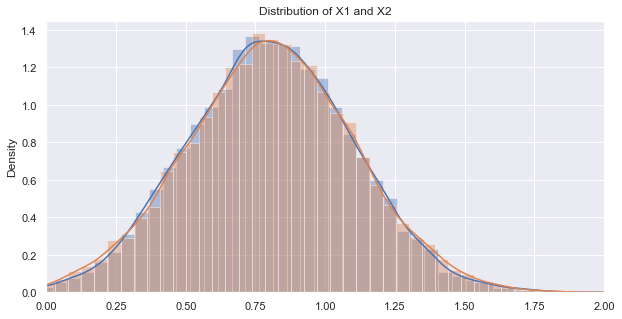

In [2]:
#The population distributions, scale is std
X_1 = stats.norm.rvs(loc = 0.8, scale = 0.3, size = 14000, random_state = None)
X_2 = stats.norm.rvs(loc = 0.81, scale = 0.3, size = 14000, random_state = None)
#X_1 = X_1[(X_1 <= 1) & (X_1 >= 0)]
#X_2 = X_2[(X_2 <= 1) & (X_2 >= 0)]

plt.figure(figsize = (10,5))
sns.distplot(X_1)
sns.distplot(X_2)
plt.xlim(0,2)
plt.title('Distribution of X1 and X2')
plt.show()

## Pre-experiment calculations

Given we want to measure a difference of 100 basis points, i.e. from 80% to 81%, how many users do we need to achieve 80% power ? Note this is a two sample, two sided z test:

- For a 50/50 split we need 14k users in each group to get 80% power

### Calculating power and sample size

In [3]:
#Z_crit
alpha = .05
beta = 0.2 #Power = 1-beta

#Paramaters
mu0,mu1 = 0.80,0.81
sigma0, sigma1 = 0.3, 0.3
n0, n1 = 10000,10000

#Intermediate calculations
z_alpha2 = stats.norm.ppf(1-alpha/2, loc=0, scale=1)
z_beta = stats.norm.ppf(1-beta, loc=0, scale=1)

kappa = n0/n1
sigma_pooled = ( np.sqrt(( (n0-1)* sigma0**2 + (n1-1) * sigma1**2 ) / (n0+n1-2)) )


#Manual power
#from http://powerandsamplesize.com/Calculators/Compare-2-Means/2-Sample-Equality
z = (mu1-mu0) / ( sigma_pooled * np.sqrt( (1/n0) + (1/n1) ) )
power_manual = stats.norm.cdf(z - z_alpha2, loc=0, scale=1) + stats.norm.cdf(-z - z_alpha2, loc=0, scale=1)

#Manual sample size given power
sample_size_n1 = (1 + 1/kappa)  * ( sigma_pooled * (z_alpha2 + z_beta) / (mu1-mu0) )**2
sample_size_n0 = kappa * sample_size_n1

#Using statsmodel and standardized effect size, difference between the two means divided by the standard deviation. effect_size has to be positive.
power_statsmodel = statsmodels.stats.power.tt_ind_solve_power(effect_size = (mu1-mu0)/sigma_pooled, nobs1 = n1, ratio =n0/n1, alpha = 0.05, power = None, alternative = 'two-sided' )

#print('z_alpha/2 = ',z_alpha2, '  z = ', z)
print('Sample size for 80% power: n0=', round(sample_size_n1), 'and n1 =',round(sample_size_n0))
print('Power for given sample size = ', round(power_manual,4) ) 


Sample size for 80% power: n0= 14128 and n1 = 14128
Power for given sample size =  0.6543


In [11]:
def ttest_two_side_power(mu0, mu1, sigma0, sigma1, n0, n1, alpha = 0.05, beta = 0.2):
    '''Manual power calculation for two sided t test power
    from http://powerandsamplesize.com/Calculators/Compare-2-Means/2-Sample-Equality
    '''
    
    #Intermediate calculations
    z_alpha2 = stats.norm.ppf(1-alpha/2, loc=0, scale=1)
    z_beta = stats.norm.ppf(1-beta, loc=0, scale=1)

    #power
    z = (mu1-mu0) / ( sigma_pooled * np.sqrt( (1/n0) + (1/n1) ) )
    pwer = stats.norm.cdf(z - z_alpha2, loc=0, scale=1) + stats.norm.cdf(-z - z_alpha2, loc=0, scale=1)
    
    return pwer


ttest_two_side_power(.8, .81, .3, .3, 14000, 14000, alpha = 0.05, beta = 0.2)    

0.7964213092264733

### Confirming by simulations 

In [12]:
%%time

#Power from simulations
means0, means1, means2 = [], [], []
t_test_p_H0, t_test_p_H1 = [], []

for i in range(5000):
    sample0 = stats.norm.rvs(loc = 0.8, scale = .3, size = n0)
    sample1 = stats.norm.rvs(loc = 0.81, scale = .3, size = n1)
    sample2 = stats.norm.rvs(loc = 0.8, scale = .3, size = n1)
    means0.append(sample0.mean().copy())
    means1.append(sample1.mean().copy())
    means2.append(sample2.mean().copy())

    #Computations for true alpha and power
    t_test_p_H0.append(stats.ttest_ind(sample0,sample2)[1].copy())
    t_test_p_H1.append(stats.ttest_ind(sample0,sample1)[1].copy())

#Computing true alpha and power from simulations
simulated_alpha = (np.asarray(t_test_p_H0) < alpha).sum() / len(t_test_p_H0)
simulated_power = (np.asarray(t_test_p_H1) < alpha).sum() / len(t_test_p_H1)


CPU times: user 21.3 s, sys: 107 ms, total: 21.4 s
Wall time: 24 s


In [13]:
print('Manual Power = ', power_manual ) 
print('Simulated power = ', simulated_power , 'and alpha =', simulated_alpha)

#Not sure why stats model gives different results ? 
#Since manual, bootstrap and website all give the same value, we will ignore statsmodel
#print('Stats model power = ', power_statsmodel)

Manual Power =  0.6543457917372257
Simulated power =  0.6408 and alpha = 0.0544


# Simulating early peeking

Assume that each day, we increase the number of users in the sample by 1,000. What would happen if we peaked only once, on day 5, every day ? 

Note that:
- x0 corresponds to the control with mean = 0.8
- x1 corresponds to a variant with true mean = 0.81 (i.e. a true alternative)
- x2 corresponds to a variant with true mean = 0.8 (i.e. a true null)


In [14]:
%%time
days = 14
sims = 500
H0_frame, H1_frame, H2_frame= np.empty(days).reshape(1,days), np.empty(days).reshape(1,days), np.empty(days).reshape(1,days)

#Looping through simulations
for i in range(sims-1):
    
    x0, x1, x2, x3 = np.empty(0), np.empty(0), np.empty(0), np.empty(0)
    t_test_p_H0, t_test_p_H1, t_test_p_H2 = np.empty(0), np.empty(0), np.empty(0)
    
    #Looping through days 
    for d in range(days):
        #print(d)
        daily_x0 = stats.norm.rvs(loc = mu0, scale =sigma0, size = 1000)
        daily_x1 = stats.norm.rvs(loc = mu1, scale = sigma1, size = 1000)
        daily_x2 = stats.norm.rvs(loc = mu0, scale = sigma0, size = 1000)
        daily_x3 = stats.norm.rvs(loc = mu0-0.03, scale = sigma0, size = 1000)

        x0 = np.append(x0, daily_x0.copy())
        x1 = np.append(x1, daily_x1.copy())
        x2 = np.append(x2, daily_x2.copy())
        x3 = np.append(x3, daily_x3.copy())
        #print(x0.shape)

        t_test_p_H0 = np.append(t_test_p_H0, stats.ttest_ind(x0,x2)[1].copy())
        t_test_p_H1 = np.append(t_test_p_H1, stats.ttest_ind(x0,x1)[1].copy())   
        t_test_p_H2 = np.append(t_test_p_H2, stats.ttest_ind(x0,x3)[1].copy())   
    
    #Stacking sim loop results
    H0_frame = np.vstack( (H0_frame,t_test_p_H0))
    H1_frame = np.vstack( (H1_frame,t_test_p_H1 ))
    H2_frame = np.vstack( (H2_frame,t_test_p_H2 ))

#Saving as DataFrame outside of the sim loop    
H0_frame = pd.DataFrame(H0_frame)
H1_frame = pd.DataFrame(H1_frame)
H2_frame = pd.DataFrame(H2_frame)

CPU times: user 24.4 s, sys: 122 ms, total: 24.6 s
Wall time: 27.5 s


## Calculations and insights
### Peeking every day 
- Inflates the true type 1 error from 5% to 20%, or a 4x increase
- Inflates the true power from 80% to 87.5%, or a 9% relative increase

In [15]:
number_sims = H0_frame.shape[0]
number_days = H0_frame.shape[1]

H0_positive_sims = ((H0_frame<alpha).sum(axis=1)>0).sum()
H1_positive_sims = ((H1_frame<alpha).sum(axis=1)>0).sum()
expected_power = ttest_two_side_power(mu0, mu1, sigma0 , sigma1, x0.shape[0], x0.shape[0], alpha = alpha, beta = beta)    

# Under a true H0, how many simulations have 1 or more day with pvalue < alpha
#print('H0 sims with 1 or more days positive =', H0_positive_sims) 

# i.e. True type 1 error in this scenario compared to expected
print('True type 1 error when peaking each day:')
print('True =', 100 *H0_positive_sims / number_sims, '%, Expected =', 100 * alpha, '%')

# Under a true H1, how many simulations have 1 or more day with pvalue < alpha
print('')
print('Power when peaking each day:')
print('True = ', 100 * H1_positive_sims / number_sims, '%, Expected =', 100* expected_power, '%')


True type 1 error when peaking each day:
True = 23.4 %, Expected = 5.0 %

Power when peaking each day:
True =  88.6 %, Expected = 79.64213092264733 %


### Visual interpretation : H0 scenario

Why does peeking inflate type I error ? Given two identical distributions, i.e. a true null hypothesis, we plot
- Top chart: the number of positive experiments and proportion of total, each day of peeking
- Bottom two charts:
    - In grey, experiments that are negative
    - In red, experiments that have a p value < 0.05, i.e. false positives

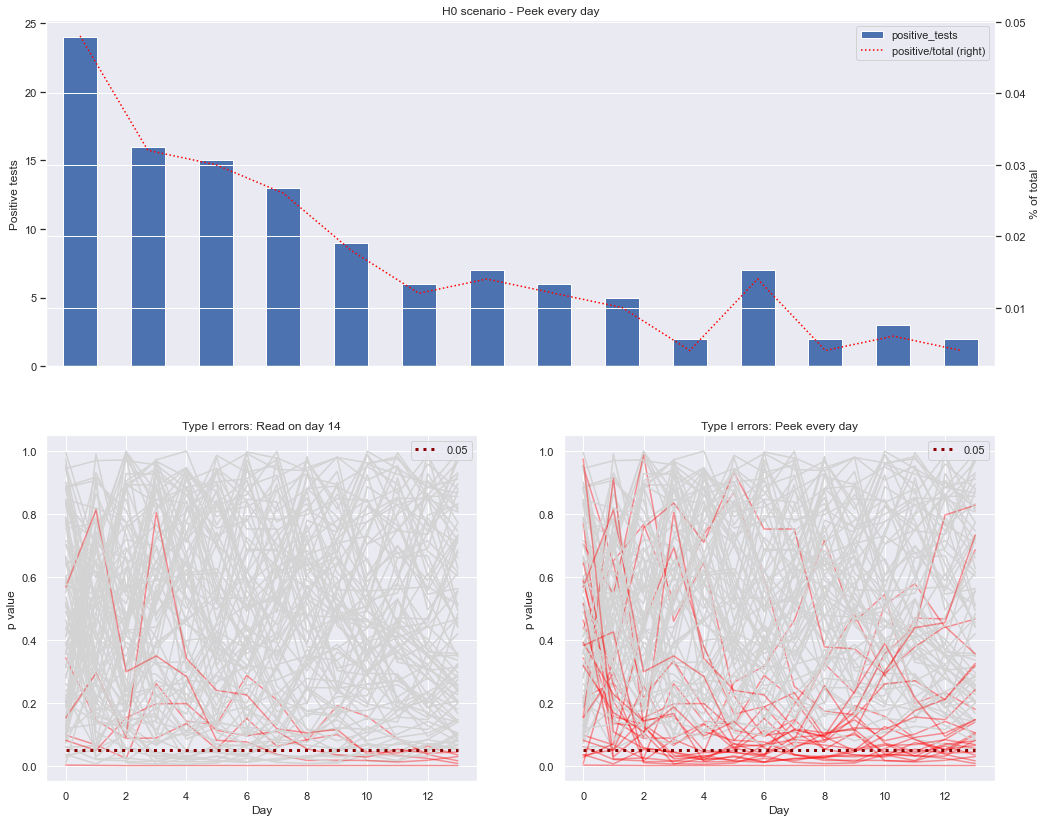

True type 1 error when peaking each day:
True = 23.4 %, Expected = 5.0 %
Sum of % of total = 0.234


In [16]:
#Calculations for the bar plot        
number_positive_tests, number_remaining_tests = [], []
H0_frame_copy = H0_frame.copy()

#Loop through columns
for c in H0_frame_copy.columns:
    
    #Calculate temp results
    positive_tests = H0_frame_copy[H0_frame_copy.iloc[:,c]<0.05].index
    number_positive_tests.append(positive_tests.shape[0])
    number_remaining_tests.append(H0_frame_copy.shape[0])
    
    #Drop the positive tests from frame
    H0_frame_copy = H0_frame_copy.drop(index = positive_tests, axis = 0)
    
#Save in frame and calculate proportions    
df_bar_res = pd.DataFrame({'Day':[c for c in H0_frame_copy.columns], 'positive_tests':number_positive_tests, \
                       'total_tests':2000,'remaining_tests':number_remaining_tests})
df_bar_res['positive/total'] = df_bar_res['positive_tests'] / H0_frame.shape[0]
 

#Figure setup
fig = plt.figure(figsize=(17,14))
layout = (2, 2)
ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
ax2 = plt.subplot2grid(layout, (1, 0))
ax3 = plt.subplot2grid(layout, (1, 1))
  
    
#Bar plot
df_bar_res.plot(kind = 'bar', x = 'Day', y = 'positive_tests', ax= ax1, ylabel = 'Positive tests', title = 'H0 scenario - Peek every day')
tmp = df_bar_res.plot(kind = 'line', x = 'Day', y = 'positive/total', color = 'red', linestyle = ':',secondary_y = True,ax = ax1)
tmp.set_xlabel('Day')
tmp.set_ylabel('% of total')

    
# Line plots
alpha_plot = [0.05 for i in range(14)]

for row in H0_frame.head(100).iterrows():
    #Non peeking plot
    if row[1][13]<0.05:
        ax2.plot(row[1], linestyle = '-', color = 'red', alpha = .4)
    else:
        ax2.plot(row[1], linestyle = '-', color = 'lightgrey')
        
    #Peeking plot
    if (row[1]<0.05).sum()>0:
        ax3.plot(row[1], linestyle = '-', color = 'red', alpha = .4)
    else:
        ax3.plot(row[1], linestyle = '-', color = 'lightgrey')
    
        
ax2.plot(alpha_plot, linestyle = ':', linewidth = 3, color = 'darkred', label = '0.05')
ax2.legend(loc = 'upper right')
ax2.set_title('Type I errors: Read on day 14')
ax2.set_ylabel('p value')
ax2.set_xlabel('Day')        
        
ax3.plot(alpha_plot, linestyle = ':', linewidth = 3, color = 'darkred', label = '0.05')
ax3.legend(loc = 'upper right')
ax3.set_title('Type I errors: Peek every day')
ax3.set_ylabel('p value')
ax3.set_xlabel('Day')

plt.show()

number_sims = H0_frame.shape[0]
number_days = H0_frame.shape[1]

H0_positive_sims = ((H0_frame<alpha).sum(axis=1)>0).sum()
expected_power = ttest_two_side_power(mu0, mu1, sigma0 , sigma1, x0.shape[0], x0.shape[0], alpha = alpha, beta = beta)    

# Under a true H0, how many simulations have 1 or more day with pvalue < alpha
#print('H0 sims with 1 or more days positive =', H0_positive_sims) 

# i.e. True type 1 error in this scenario compared to expected
print('True type 1 error when peaking each day:')
print('True =', 100 *H0_positive_sims / number_sims, '%, Expected =', 100 * alpha, '%')
print('Sum of % of total =',round(df_bar_res['positive/total'].sum(),3))


### Visual interpretation : H1 scenario

Why does peeking inflate power ? Given two truly differeny distributions, i.e. a true alternative hypothesis, we plot
- Top chart: the number of positive experiments and proportion of total, each day of peeking
- Bottom two charts:
    - In grey, experiments that are negative
    - In red, experiments that have a p value < 0.05, i.e. true positives

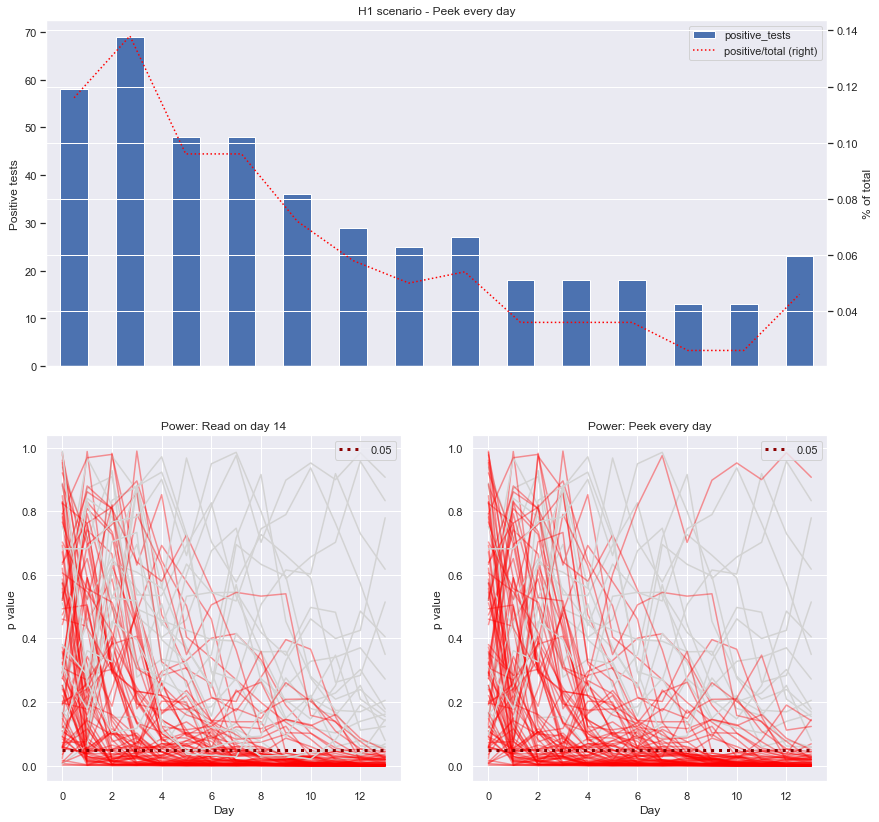


Power when peaking each day:
True =  88.6 %, Expected = 79.64213092264733 %
Sum of % of total = 0.886


In [17]:
#Calculations for the bar plot        
number_positive_tests, number_remaining_tests = [], []
H1_frame_copy = H1_frame.copy()

#Loop through columns
for c in H1_frame_copy.columns:
    
    #Calculate temp results
    positive_tests = H1_frame_copy[H1_frame_copy.iloc[:,c]<0.05].index
    number_positive_tests.append(positive_tests.shape[0])
    number_remaining_tests.append(H1_frame_copy.shape[0])
    
    #Drop the positive tests from frame
    H1_frame_copy = H1_frame_copy.drop(index = positive_tests, axis = 0)
    
#Save in frame and calculate proportions    
df_bar_res = pd.DataFrame({'Day':[c for c in H1_frame_copy.columns], 'positive_tests':number_positive_tests, \
                       'total_tests':2000,'remaining_tests':number_remaining_tests})
df_bar_res['positive/total'] = df_bar_res['positive_tests'] / H1_frame.shape[0]
 

#Figure setup
fig = plt.figure(figsize=(14,14))
layout = (2, 2)
ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
ax2 = plt.subplot2grid(layout, (1, 0))
ax3 = plt.subplot2grid(layout, (1, 1))
  
    
#Bar plot
df_bar_res.plot(kind = 'bar', x = 'Day', y = 'positive_tests', ax= ax1, xlabel = 'Day of peek', ylabel = 'Positive tests', title = 'H1 scenario - Peek every day')
tmp = df_bar_res.plot(kind = 'line', x = 'Day', y = 'positive/total', color = 'red', linestyle = ':',secondary_y = True,ax = ax1)
tmp.set_ylabel('% of total')
    
# Line plots
alpha_plot = [0.05 for i in range(14)]

for row in H1_frame.head(100).iterrows():
    #Non peeking plot
    if row[1][13]<0.05:
        ax2.plot(row[1], linestyle = '-', color = 'red', alpha = .4)
    else:
        ax2.plot(row[1], linestyle = '-', color = 'lightgrey')
        
    #Peeking plot
    if (row[1]<0.05).sum()>0:
        ax3.plot(row[1], linestyle = '-', color = 'red', alpha = .4)
    else:
        ax3.plot(row[1], linestyle = '-', color = 'lightgrey')
    
        
ax2.plot(alpha_plot, linestyle = ':', linewidth = 3, color = 'darkred', label = '0.05')
ax2.legend(loc = 'upper right')
ax2.set_title('Power: Read on day 14')
ax2.set_ylabel('p value')
ax2.set_xlabel('Day')        
        
ax3.plot(alpha_plot, linestyle = ':', linewidth = 3, color = 'darkred', label = '0.05')
ax3.legend(loc = 'upper right')
ax3.set_title('Power: Peek every day')
ax3.set_ylabel('p value')
ax3.set_xlabel('Day')

plt.show()


#Printing sums and overal stats
number_sims = H0_frame.shape[0]
number_days = H0_frame.shape[1]

H1_positive_sims = ((H1_frame<alpha).sum(axis=1)>0).sum()
expected_power = ttest_two_side_power(mu0, mu1, sigma0 , sigma1, x0.shape[0], x0.shape[0], alpha = alpha, beta = beta)    

# Under a true H1, how many simulations have 1 or more day with pvalue < alpha
print('')
print('Power when peaking each day:')
print('True = ', 100 * H1_positive_sims / number_sims, '%, Expected =', 100* expected_power, '%')
print('Sum of % of total =',round(df_bar_res['positive/total'].sum(),3))


## Effect of peeking as a function of the day of peek

### Type 1 error for 2 day peeking, as a function of the day 

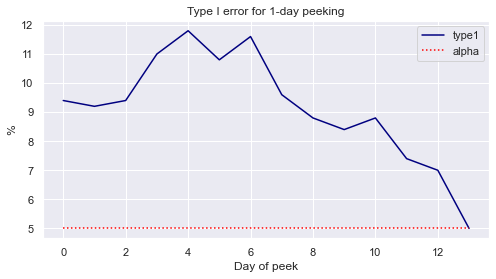

In [18]:
type1_error, days = [], []
alpha_plot = [5 for i in range(14)]

for d in range(14):
    H0_positive_sims = ((H0_frame.iloc[:,d]< 0.05) | (H0_frame.iloc[:,13]< 0.05)).sum() 
    H1_positive_sims = ((H1_frame.iloc[:,d]< 0.05) | (H1_frame.iloc[:,13]< 0.05)).sum() 

    type1_error.append(100 *H0_positive_sims / number_sims)
    days.append(d)

#Plotting    
result_df = pd.DataFrame(index =days, data = {'type1':type1_error,'alpha':alpha_plot})    
result_df.plot(style= ['-',':'],color = ['navy', 'red'],xlabel = 'Day of peek', ylabel = '%', title = 'Type I error for 1-day peeking', figsize = (8,4))
plt.show()

### Type 1 error for 2 day peeking, as a function of the day 

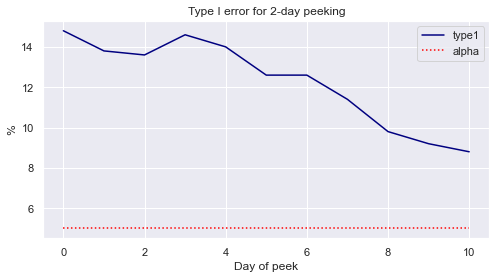

In [19]:
type1_error, days = [], []
alpha_plot = [5 for i in range(11)]

for d in range(14):
    try:
        H0_positive_sims = ((H0_frame.iloc[:,d]< 0.05) | (H0_frame.iloc[:,d+3]< 0.05) | (H0_frame.iloc[:,13]< 0.05)).sum() 
        H1_positive_sims = ((H1_frame.iloc[:,d]< 0.05) | (H0_frame.iloc[:,d+3]< 0.05) |(H1_frame.iloc[:,13]< 0.05)).sum() 
    except:
        break
        
    type1_error.append(100 *H0_positive_sims / number_sims)
    days.append(d)

#Plotting    
result_df = pd.DataFrame(index =days, data = {'type1':type1_error,'alpha':alpha_plot})    
result_df.plot(style= ['-',':'],color = ['navy', 'red'],xlabel = 'Day of peek', ylabel = '%', title = 'Type I error for 2-day peeking', figsize = (8,4))
plt.show()

## Does waiting for 2 or more successive days with significant p-value help ? 

Instead of ending the experiment once a daily peek is statistically significant, what happens if we require successive days of significant result ? For example, two days with p value < 0.5  ? 

Assuming that the decision to end the experiment is made if either:
- We see D consecutive days with statistically significant p value
- OR 
- Test is stat sig on the last day (when sample size is reached) 

As we increase the number D consecutive days we decrease the inflated type I error from
- 13% for 2+ consecutive days
- 6.5% for 6 consecutive days 
- 5.5 for 12 consecutive days 

If we change the decision logic to ONLY based on consecutive days, then the impact is much stronger on the type 1 error, but at the expense of power. This is expected, since the experiment is under-powered before day 14.


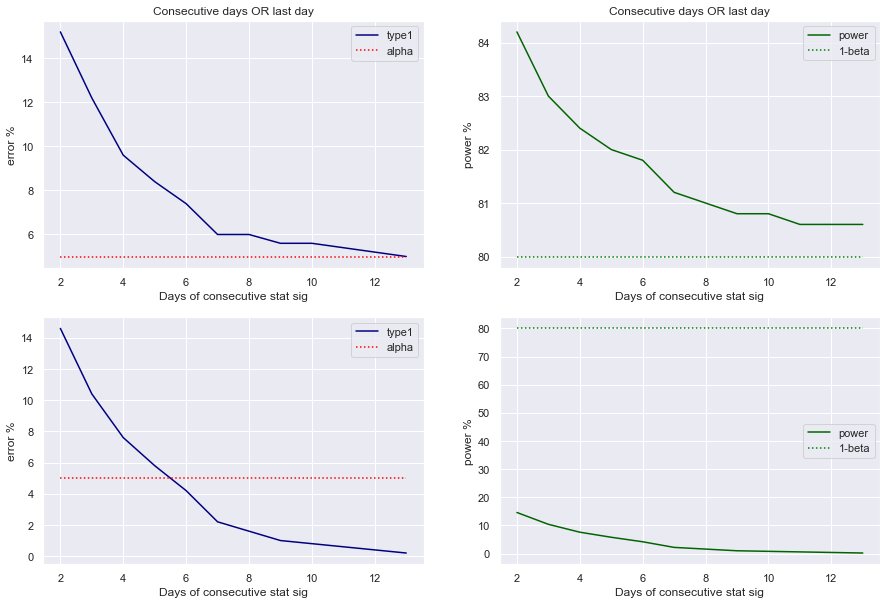

In [20]:
#Transposing table to get columns for each simulation (i.e. 2k cols) and stat sig p values
df = H0_frame.T < 0.05

#Taken from https://stackoverflow.com/questions/52717996/how-can-i-count-the-number-of-consecutive-trues-in-a-dataframe?noredirect=1&lq=1
b = df.cumsum()
c = b.sub(b.mask(df).ffill().fillna(0)).astype(int)
mask = df.any()
consec_true = np.where(mask, c.max(), -1)

#Save to DF
H0_frame['max_consec_true'] = consec_true
del df

#Repeat the above for H1 data
df = H1_frame.T < 0.05
b = df.cumsum()
c = b.sub(b.mask(df).ffill().fillna(0)).astype(int)
mask = df.any()
consec_true = np.where(mask, c.max(), -1)
H1_frame['max_consec_true'] = consec_true

# plotting
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
ax = ax.flatten()
type1_error, days, power_list = [], [], []
alpha_plot = [5 for i in range(2,14)]
beta_plot = [80 for i in range(2,14)]


#Plotting the OR scenario
for d in range(2,14):
    type1_error.append(100 * H0_frame[(H0_frame['max_consec_true'] >= d ) | (H0_frame.iloc[:,13] < 0.05 )].shape[0] / H0_frame.shape[0])
    power_list.append(100 * H1_frame[(H0_frame['max_consec_true'] >= d ) | (H1_frame.iloc[:,13] < 0.05 )].shape[0] / H1_frame.shape[0])                                                                                                        
    days.append(d)
   
result_df1 = pd.DataFrame(index =days, data = {'type1':type1_error,'alpha':alpha_plot})    
result_df2 = pd.DataFrame(index =days, data = {'power':power_list,'1-beta':beta_plot})    
result_df1.plot(style= ['-',':'],color = ['navy','red'],xlabel = 'Days of consecutive stat sig', ylabel = 'error %', title = 'Consecutive days OR last day', ax = ax[0])
result_df2.plot(style= ['-',':'],color = ['darkgreen','green'],xlabel = 'Days of consecutive stat sig', ylabel = 'power %', title = 'Consecutive days OR last day', ax = ax[1])


#Plotting the CONSECUTIVE ONLY scenario
type1_error, days, power_list = [], [], []

for d in range(2,14):
    type1_error.append(100 * H0_frame[(H0_frame['max_consec_true'] >= d ) ].shape[0] / H0_frame.shape[0])
    power_list.append(100 * H1_frame[(H0_frame['max_consec_true'] >= d ) ].shape[0] / H1_frame.shape[0])                                                                                                        
    days.append(d)

result_df3 = pd.DataFrame(index =days, data = {'type1':type1_error,'alpha':alpha_plot})    
result_df4 = pd.DataFrame(index =days, data = {'power':power_list,'1-beta':beta_plot})    
result_df3.plot(style= ['-',':'],color = ['navy','red'],xlabel = 'Days of consecutive stat sig', ylabel = 'error %', ax = ax[2])
result_df4.plot(style= ['-',':'],color = ['darkgreen','green'],xlabel = 'Days of consecutive stat sig', ylabel = 'power %',  ax = ax[3])

plt.show()

H0_frame = H0_frame.drop(columns = ['max_consec_true'])
H1_frame = H1_frame.drop(columns = ['max_consec_true'])


# Can we make early decisions when the p-values excede a certain threshold ? 

Can we find a trade-off between early decisions (peeking) and experiment velocity ? Are there boundaries and conditions under which we are comfortable peeking and making an early decision ? 

For simplicity, let's assume that we are willing to peek only once at 50% of sample size. What is the minimum and maximum p-value for which the type I error and power are within an acceptable range ? (range to be defined) 



### Futility boundary

Imagine that an experiment has a high p-value at its mid point, how likely is it to turn out to be significant once it concludes ? In other words, can we determine before the end that it is a *futile* experiment that could be stopped early ? 

The answer depends on:
- The threshold p-value, i.e. the futility threshold: $\lambda$
- The true underlying distribution of the variant: $\mu_0$ and $\mu_1$ 

Let us define the following terms:

**Correct futile**: this is an experiment that we choose to stop early which **would not** have been significant on the last day: $p_{50\%} > \lambda$ and $p_{100\%} > \alpha = 0.05$. Correct futile experiments are a benefit as they allow us to iterate quickly.  

**Incorrect futile**: this is an experiment that we choose to stop early which **would** have been significant on the last day: $p_{50\%} > \lambda$ and $p_{100\%} < \alpha = 0.05$. Incorrect futile experiments are a cost, as they reduce the true power of the experiment (i.e. we fail to detect a true change) 



Sources: 
- https://cxl.com/blog/peeking-sequential-testing/, 
- http://blog.analytics-toolkit.com/2017/futility-stopping-rules-agile-ab-testing/
note that correct / incorrect futility is something I came up with.

## Sample calculations: H1 and H0 scenario


In [21]:
print('Futility threshold = 0.5')

# H1 scenario
print('H1 scenario: mu0 = 0.80, mu1 = 0.81')
# POWER
#H1 tests that reach p < 0.05 at the end of testday 14 = 784 (78%)
print('Total tests =' ,H1_frame.shape[0])
print('POWER =',100.0 * (H1_frame.iloc[:,13]<0.05).sum() / H1_frame.shape[0], '%')

#FUTILITY
#H1 tests that had pvalue >0.5 on day 7  = 103 (10.3%)
print('FUTILE TESTS = ',(H1_frame.iloc[:,6]>0.50).sum())
print('FUTILE % = ', 100.0 * (H1_frame.iloc[:,6]>0.50).sum() /H1_frame.shape[0], '%')

#INCORRECT FUTILITY
#H1 tests that had pvalue >0.5 on day 7  = 103 (10.3%)
# AND reached p < 0.05 confidence at the end of test = 33
print('INCORRECT FUTILE TESTS =',100.0*H1_frame[(H1_frame.iloc[:,6]>0.50) & (H1_frame.iloc[:,13]<0.05)].shape[0] /H1_frame.shape[0], '%')

#CORRECT FUTILITY
#H1 tests that had pvalue >0.5 on day 7  = 103 (10.3%)
# AND DID NOT reached p < 0.05 confidence at the end of test = 33
print('CORRECT FUTILE TESTS =',100.0*H1_frame[(H1_frame.iloc[:,6]>0.50) & (H1_frame.iloc[:,13]>0.05)].shape[0] /H1_frame.shape[0], '%')


####################
# H0 scenario
print()
print('-----------------')
print('H1 scenario: mu0 = 0.80, mu1 = 0.80')
# POWER
#H1 tests that reach p < 0.05 at the end of testday 14 = 784 (78%)
print('Total tests =' ,H0_frame.shape[0])
print('Type I error =',100.0 * (H0_frame.iloc[:,13]<0.05).sum() / H0_frame.shape[0], '%')

#FUTILITY
#H1 tests that had pvalue >0.5 on day 7  = 103 (10.3%)
print('FUTILE TESTS = ',(H0_frame.iloc[:,6]>0.50).sum())
print('FUTILE % = ', 100.0 * (H0_frame.iloc[:,6]>0.50).sum() /H0_frame.shape[0], '%')

#INCORRECT FUTILITY
#H1 tests that had pvalue >0.5 on day 7  = 103 (10.3%)
# AND reached p < 0.05 confidence at the end of test = 33
print('INCORRECT FUTILE TESTS =',100.0*H0_frame[(H0_frame.iloc[:,6]>0.50) & (H0_frame.iloc[:,13]<0.05)].shape[0] /H0_frame.shape[0], '%')

#CORRECT FUTILITY
#H1 tests that had pvalue >0.5 on day 7  = 103 (10.3%)
# AND DID NOT reached p < 0.05 confidence at the end of test = 33
print('CORRECT FUTILE TESTS =',100.0*H0_frame[(H0_frame.iloc[:,6]>0.50) & (H0_frame.iloc[:,13]>0.05)].shape[0] /H0_frame.shape[0], '%')

Futility threshold = 0.5
H1 scenario: mu0 = 0.80, mu1 = 0.81
Total tests = 500
POWER = 80.6 %
FUTILE TESTS =  49
FUTILE % =  9.8 %
INCORRECT FUTILE TESTS = 4.2 %
CORRECT FUTILE TESTS = 5.6 %

-----------------
H1 scenario: mu0 = 0.80, mu1 = 0.80
Total tests = 500
Type I error = 5.0 %
FUTILE TESTS =  243
FUTILE % =  48.6 %
INCORRECT FUTILE TESTS = 0.8 %
CORRECT FUTILE TESTS = 47.8 %


## Trade-off between correct and incorrect futility

Assuming a single, fixed peek at 50% sample size (i.e. day 7 in this simulation), we can vary the threshold $\lambda$ and calculate the trade-off between correct and incorrect futility for both H1 and H0 scenarios

If we wish to keep the number of incorrectly stopped experiments under the alternative hypothesis i.e. H1 incorrect futile, to less than 2%, then we pick a threshold p value on day 7 of p > 0.55


## Impact on type I error and power 

Combining the futility threshold of a single peek on day 7 with a final reading on day 14, we can calculate the overall impact on type I, type II error and power of peeking vs non peeking. Recall that: 
- False negative (H1) = 1-Power or Type II
- True positive (H1) = Power
- True negative (H0) 
- False positive (H0) = Type I error

Here we see that for a futility threshold of 0.55, we get:

**Pros**
- 44% of H0 experiments are correctly stopped on day 7 since they are deemed *futile*
- A 0.6% reduction in False Positive (Type I error) from 5% to 4.44%

**Cons**
- A 2% reduction in True Positive (Power) from 79% to 77% in the case of H1





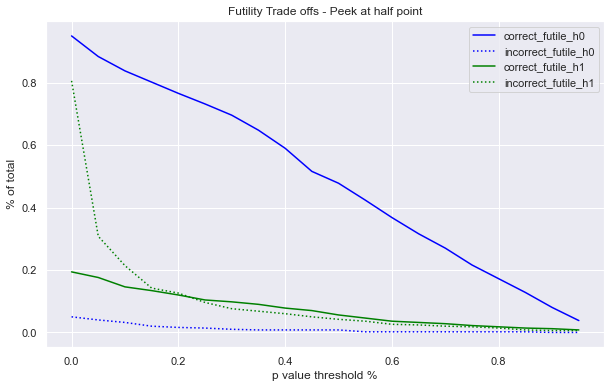

,days,threshold,false_negative_peek,true_positive_peek,true_negative_peek,false_positive_peek,incorrect_futile_h0,correct_futile_h0,incorrect_futile_h1,correct_futile_h1,false_negative_no_peek,true_positive_no_peek,true_negative_no_peek,false_positive_no_peek
0,7,0.00000,1.00000,0.00000,1.00000,0.00000,0.05000,0.95000,0.80600,0.19400,0.19400,0.80600,0.95000,0.05000
1,7,0.05000,0.50200,0.49800,0.99000,0.01000,0.04000,0.88400,0.30800,0.17600,0.19400,0.80600,0.95000,0.05000
2,7,0.10000,0.40800,0.59200,0.98200,0.01800,0.03200,0.83800,0.21400,0.14600,0.19400,0.80600,0.95000,0.05000
3,7,0.15000,0.33600,0.66400,0.97000,0.03000,0.02000,0.80200,0.14200,0.13400,0.19400,0.80600,0.95000,0.05000
4,7,0.20000,0.32000,0.68000,0.96600,0.03400,0.01600,0.76600,0.12600,0.12000,0.19400,0.80600,0.95000,0.05000
5,7,0.25000,0.29000,0.71000,0.96400,0.03600,0.01400,0.73200,0.09600,0.10400,0.19400,0.80600,0.95000,0.05000
6,7,0.30000,0.27000,0.73000,0.96000,0.04000,0.01000,0.69600,0.07600,0.09800,0.19400,0.80600,0.95000,0.05000
7,7,0.35000,0.26200,0.73800,0.95800,0.04200,0.00800,0.64800,0.06800,0.09000,0.19400,0.80600,0.95000,0.05000
8,7,0.40000,0.25400,0.74600,0.95800,0.04200,0.00800,0.59000,0.06000,0.07800,0.19400,0.80600,0.95000,0.05000
9,7,0.45000,0.24400,0.75600,0.95800,0.04200,0.00800,0.51600,0.05000,0.07000,0.19400,0.80600,0.95000,0.05000


In [22]:
#Futility cost as a function of day of peek
#i.e. reduction in power
threshold = []
#days = [6 for d in range(13)]
d = 6
incorrect_futile_h1, correct_futile_h1 = [], []
incorrect_futile_h0, correct_futile_h0 = [], []

false_negative_peek, true_positive_peek = [], [] #H1
true_negative_peek, false_positive_peek = [], [] #H0

false_negative_no_peek, true_positive_no_peek = [], []
true_negative_no_peek, false_positive_no_peek = [], []



for t in range(0,20,1):
    threshold.append(t/20)
    days.append(d)
    
    #Peek calculations
    false_negative_peek.append(H1_frame[(H1_frame.iloc[:,d]>(t/20)) | (H1_frame.iloc[:,13]>0.05)].shape[0] / H1_frame.shape[0])
    true_positive_peek.append(H1_frame[(H1_frame.iloc[:,d]<(t/20)) & (H1_frame.iloc[:,13]<0.05)].shape[0] / H1_frame.shape[0])
    
    true_negative_peek.append(H0_frame[(H0_frame.iloc[:,d]>(t/20)) | (H0_frame.iloc[:,13]>0.05)].shape[0] / H0_frame.shape[0])
    false_positive_peek.append(H0_frame[(H0_frame.iloc[:,d]<(t/20)) & (H0_frame.iloc[:,13]<0.05)].shape[0] / H0_frame.shape[0])
    
    #Futility
    incorrect_futile_h1.append(H1_frame[(H1_frame.iloc[:,d]>(t/20)) & (H1_frame.iloc[:,13]<0.05)].shape[0] / H1_frame.shape[0])
    correct_futile_h1.append(H1_frame[(H1_frame.iloc[:,d]>(t/20)) & (H1_frame.iloc[:,13]>0.05)].shape[0] / H1_frame.shape[0])
    incorrect_futile_h0.append(H1_frame[(H0_frame.iloc[:,d]>(t/20)) & (H0_frame.iloc[:,13]<0.05)].shape[0] / H0_frame.shape[0])
    correct_futile_h0.append(H1_frame[(H0_frame.iloc[:,d]>(t/20)) & (H0_frame.iloc[:,13]>0.05)].shape[0] / H0_frame.shape[0])


    #No peek calculations
    false_negative_no_peek.append(H1_frame[(H1_frame.iloc[:,13]>0.05)].shape[0] / H1_frame.shape[0])
    true_positive_no_peek.append(H1_frame[(H1_frame.iloc[:,13]<0.05)].shape[0] / H1_frame.shape[0])
    
    true_negative_no_peek.append(H0_frame[(H0_frame.iloc[:,13]>0.05)].shape[0] / H0_frame.shape[0])
    false_positive_no_peek.append(H0_frame[(H0_frame.iloc[:,13]<0.05)].shape[0] / H0_frame.shape[0])

        
    
detailed_res_df = pd.DataFrame({'days':d+1, 'threshold':threshold, \
                        'false_negative_peek':false_negative_peek, 'true_positive_peek':true_positive_peek, \
                         'true_negative_peek':true_negative_peek, 'false_positive_peek':false_positive_peek, \
                         'incorrect_futile_h0':incorrect_futile_h0, 'correct_futile_h0':correct_futile_h0, \
                         'incorrect_futile_h1':incorrect_futile_h1, 'correct_futile_h1':correct_futile_h1, \
                         'false_negative_no_peek':false_negative_no_peek, 'true_positive_no_peek':true_positive_no_peek, \
                         'true_negative_no_peek':true_negative_no_peek, 'false_positive_no_peek':false_positive_no_peek,})

    
detailed_res_df.plot(x = 'threshold', y = ['correct_futile_h0','incorrect_futile_h0','correct_futile_h1','incorrect_futile_h1'], \
                       color = ['blue', 'blue', 'green', 'green'], style = ['-',':','-',':'], figsize = (10,6), \
                       ylabel = '% of total', xlabel = 'p value threshold %',title = 'Futility Trade offs - Peek at half point')


plt.show()
detailed_res_df

## Efficacy boundary

Conversely if the experiment has a *low* p-value at its mid point, can we make an early decision that the experiment is effective and should be rolled out ? 

Let us define the following terms:

**Correct effective**: experiment that we choose to rollout early which **would** have been significant on the last day: $p_{50\%} < \lambda$ and $p_{100\%} < \alpha = 0.05$. Correct effective experiments are a benefit as they allow us to iterate quickly.  

**Incorrect effective**: this is an experiment that we choose to rollout early which **would not** have been significant on the last day: $p_{50\%} < \lambda$ and $p_{100\%} > \alpha = 0.05$. Incorrect futile experiments are a cost, as they increase the type I error of the experiment (i.e. false positive) 

If we wish to keep the number of incorrectly rolledout experiments under the null hypothesis i.e. H0 incorrect effective, to less than 2%, then we pick a threshold p value on day 7 of p < 0.0.03

This will give us the following impact: 

**Pros**
- 40% of H1 experiments are correctly rolled out on day 7 since they are deemed *effective*
- A 1% increase in True Positive (Power) from 79% to 80% in the case of H1 

**Cons**
- A 2% increase in False Positive (type I error) from 5 to 7% in the case of H0




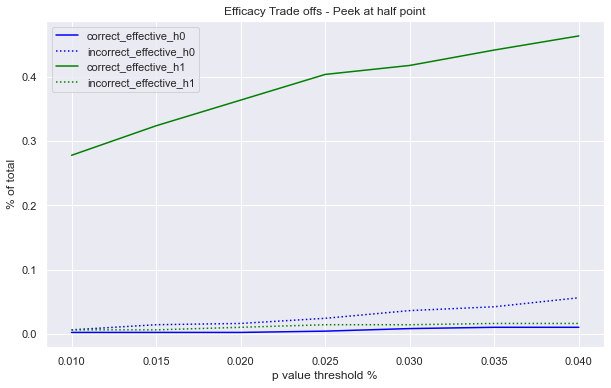

,days,threshold,false_negative_peek,true_positive_peek,true_negative_peek,false_positive_peek,incorrect_effective_h0,correct_effective_h0,incorrect_effective_h1,correct_effective_h1,false_negative_no_peek,true_positive_no_peek,true_negative_no_peek,false_positive_no_peek
0,7,0.01000,0.18800,0.81200,0.94400,0.05600,0.00600,0.00200,0.00600,0.27800,0.19400,0.80600,0.95000,0.05000
1,7,0.01500,0.18800,0.81200,0.93600,0.06400,0.01400,0.00200,0.00600,0.32400,0.19400,0.80600,0.95000,0.05000
2,7,0.02000,0.18400,0.81600,0.93400,0.06600,0.01600,0.00200,0.01000,0.36400,0.19400,0.80600,0.95000,0.05000
3,7,0.02500,0.18000,0.82000,0.92600,0.07400,0.02400,0.00400,0.01400,0.40400,0.19400,0.80600,0.95000,0.05000
4,7,0.03000,0.18000,0.82000,0.91400,0.08600,0.03600,0.00800,0.01400,0.41800,0.19400,0.80600,0.95000,0.05000
5,7,0.03500,0.17800,0.82200,0.90800,0.09200,0.04200,0.01000,0.01600,0.44200,0.19400,0.80600,0.95000,0.05000
6,7,0.04000,0.17800,0.82200,0.89400,0.10600,0.05600,0.01000,0.01600,0.46400,0.19400,0.80600,0.95000,0.05000


In [23]:
#Futility cost as a function of day of peek
#i.e. reduction in power
threshold = []
#days = [6 for d in range(13)]
d = 6
incorrect_effective_h1, correct_effective_h1 = [], []
incorrect_effective_h0, correct_effective_h0 = [], []

false_negative_peek, true_positive_peek = [], [] #H1
true_negative_peek, false_positive_peek = [], [] #H0

false_negative_no_peek, true_positive_no_peek = [], []
true_negative_no_peek, false_positive_no_peek = [], []



for t in [0.01,0.015,0.02,0.025,0.03,0.035,0.04]:
    threshold.append(t)
    days.append(d)
    
    #Peek calculations
    false_negative_peek.append(H1_frame[(H1_frame.iloc[:,d]>(t)) & (H1_frame.iloc[:,13]>0.05)].shape[0] / H1_frame.shape[0])
    true_positive_peek.append(H1_frame[(H1_frame.iloc[:,d]<(t)) | (H1_frame.iloc[:,13]<0.05)].shape[0] / H1_frame.shape[0])
    
    true_negative_peek.append(H0_frame[(H0_frame.iloc[:,d]>(t)) & (H0_frame.iloc[:,13]>0.05)].shape[0] / H0_frame.shape[0])
    false_positive_peek.append(H0_frame[(H0_frame.iloc[:,d]<(t)) | (H0_frame.iloc[:,13]<0.05)].shape[0] / H0_frame.shape[0])
    
    #Efficacy
    incorrect_effective_h1.append(H1_frame[(H1_frame.iloc[:,d]<(t)) & (H1_frame.iloc[:,13]>0.05)].shape[0] / H1_frame.shape[0])
    correct_effective_h1.append(H1_frame[(H1_frame.iloc[:,d]<(t)) & (H1_frame.iloc[:,13]<0.05)].shape[0] / H1_frame.shape[0])
    incorrect_effective_h0.append(H1_frame[(H0_frame.iloc[:,d]<(t)) & (H0_frame.iloc[:,13]>0.05)].shape[0] / H0_frame.shape[0])
    correct_effective_h0.append(H1_frame[(H0_frame.iloc[:,d]<(t)) & (H0_frame.iloc[:,13]<0.05)].shape[0] / H0_frame.shape[0])


    #No peek calculations
    false_negative_no_peek.append(H1_frame[(H1_frame.iloc[:,13]>0.05)].shape[0] / H1_frame.shape[0])
    true_positive_no_peek.append(H1_frame[(H1_frame.iloc[:,13]<0.05)].shape[0] / H1_frame.shape[0])
    
    true_negative_no_peek.append(H0_frame[(H0_frame.iloc[:,13]>0.05)].shape[0] / H0_frame.shape[0])
    false_positive_no_peek.append(H0_frame[(H0_frame.iloc[:,13]<0.05)].shape[0] / H0_frame.shape[0])

        
    
detailed_res_df = pd.DataFrame({'days':d+1, 'threshold':threshold, \
                        'false_negative_peek':false_negative_peek, 'true_positive_peek':true_positive_peek, \
                         'true_negative_peek':true_negative_peek, 'false_positive_peek':false_positive_peek, \
                         'incorrect_effective_h0':incorrect_effective_h0, 'correct_effective_h0':correct_effective_h0, \
                         'incorrect_effective_h1':incorrect_effective_h1, 'correct_effective_h1':correct_effective_h1, \
                         'false_negative_no_peek':false_negative_no_peek, 'true_positive_no_peek':true_positive_no_peek, \
                         'true_negative_no_peek':true_negative_no_peek, 'false_positive_no_peek':false_positive_no_peek,})

    
detailed_res_df.plot(x = 'threshold', y = ['correct_effective_h0','incorrect_effective_h0','correct_effective_h1','incorrect_effective_h1'], \
                       color = ['blue', 'blue', 'green', 'green'], style = ['-',':','-',':'], figsize = (10,6), \
                       ylabel = '% of total', xlabel = 'p value threshold %',title = 'Efficacy Trade offs - Peek at half point')


plt.show()
detailed_res_df

## Peaking 2 times at 50% and 75% of sample size

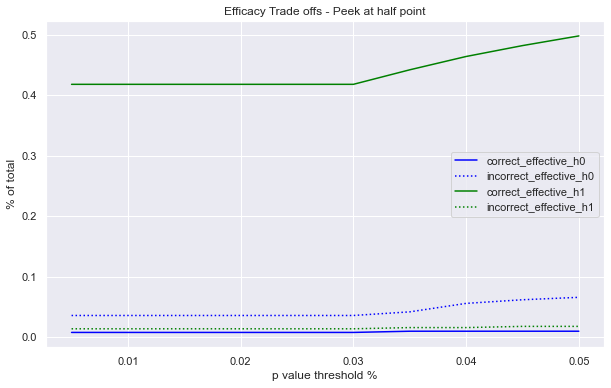

,days,threshold,false_negative_peek,true_positive_peek,true_negative_peek,false_positive_peek,incorrect_effective_h0,correct_effective_h0,incorrect_effective_h1,correct_effective_h1,false_negative_no_peek,true_positive_no_peek,true_negative_no_peek,false_positive_no_peek
0,7,0.00500,0.18000,0.82000,0.91400,0.08600,0.03600,0.00800,0.01400,0.41800,0.19400,0.80600,0.95000,0.05000
1,7,0.01000,0.18000,0.82000,0.91400,0.08600,0.03600,0.00800,0.01400,0.41800,0.19400,0.80600,0.95000,0.05000
2,7,0.01500,0.18000,0.82000,0.91400,0.08600,0.03600,0.00800,0.01400,0.41800,0.19400,0.80600,0.95000,0.05000
3,7,0.02000,0.18000,0.82000,0.91400,0.08600,0.03600,0.00800,0.01400,0.41800,0.19400,0.80600,0.95000,0.05000
4,7,0.02500,0.18000,0.82000,0.91400,0.08600,0.03600,0.00800,0.01400,0.41800,0.19400,0.80600,0.95000,0.05000
5,7,0.03000,0.18000,0.82000,0.91400,0.08600,0.03600,0.00800,0.01400,0.41800,0.19400,0.80600,0.95000,0.05000
6,7,0.03500,0.17800,0.82200,0.90800,0.09200,0.04200,0.01000,0.01600,0.44200,0.19400,0.80600,0.95000,0.05000
7,7,0.04000,0.17800,0.82200,0.89400,0.10600,0.05600,0.01000,0.01600,0.46400,0.19400,0.80600,0.95000,0.05000
8,7,0.04500,0.17600,0.82400,0.88800,0.11200,0.06200,0.01000,0.01800,0.48200,0.19400,0.80600,0.95000,0.05000
9,7,0.05000,0.17600,0.82400,0.88400,0.11600,0.06600,0.01000,0.01800,0.49800,0.19400,0.80600,0.95000,0.05000


In [24]:
#Futility cost as a function of day of peek
#i.e. reduction in power
threshold = []
#days = [6 for d in range(13)]
d1, d2 = 6, 10
incorrect_effective_h1, correct_effective_h1 = [], []
incorrect_effective_h0, correct_effective_h0 = [], []

false_negative_peek, true_positive_peek = [], [] #H1
true_negative_peek, false_positive_peek = [], [] #H0

false_negative_no_peek, true_positive_no_peek = [], []
true_negative_no_peek, false_positive_no_peek = [], []

t1 = 0.030


for t2 in [0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04, 0.045, 0.05]:
    threshold.append(t2)
    
    #Peek calculations
    false_negative_peek.append(H1_frame[(H1_frame.iloc[:,d1]>t1 ) & (H1_frame.iloc[:,d1]>t2) & (H1_frame.iloc[:,13]>0.05)].shape[0] / H1_frame.shape[0])
    true_positive_peek.append(H1_frame[(H1_frame.iloc[:,d]<t1) | (H1_frame.iloc[:,d]<t2) | (H1_frame.iloc[:,13]<0.05)].shape[0] / H1_frame.shape[0])
    
    true_negative_peek.append(H0_frame[(H0_frame.iloc[:,d]>t1) & (H0_frame.iloc[:,d]>t2) & (H0_frame.iloc[:,13]>0.05)].shape[0] / H0_frame.shape[0])
    false_positive_peek.append(H0_frame[(H0_frame.iloc[:,d]<t1) | (H0_frame.iloc[:,d]<t2) | (H0_frame.iloc[:,13]<0.05)].shape[0] / H0_frame.shape[0])
    
    #Efficacy
    incorrect_effective_h1.append(H1_frame[( (H1_frame.iloc[:,d]<t1) | (H1_frame.iloc[:,d]<t2) ) & (H1_frame.iloc[:,13]>0.05)].shape[0] / H1_frame.shape[0])
    correct_effective_h1.append(H1_frame[( (H1_frame.iloc[:,d]<t1) | (H1_frame.iloc[:,d]<t2) ) & (H1_frame.iloc[:,13]<0.05)].shape[0] / H1_frame.shape[0])
    incorrect_effective_h0.append(H1_frame[( (H0_frame.iloc[:,d]<t1) | (H0_frame.iloc[:,d]<t2) ) & (H0_frame.iloc[:,13]>0.05)].shape[0] / H0_frame.shape[0])
    correct_effective_h0.append(H1_frame[( (H0_frame.iloc[:,d]<t1) | (H0_frame.iloc[:,d]<t2) ) & (H0_frame.iloc[:,13]<0.05)].shape[0] / H0_frame.shape[0])


    #No peek calculations
    false_negative_no_peek.append(H1_frame[(H1_frame.iloc[:,13]>0.05)].shape[0] / H1_frame.shape[0])
    true_positive_no_peek.append(H1_frame[(H1_frame.iloc[:,13]<0.05)].shape[0] / H1_frame.shape[0])
    
    true_negative_no_peek.append(H0_frame[(H0_frame.iloc[:,13]>0.05)].shape[0] / H0_frame.shape[0])
    false_positive_no_peek.append(H0_frame[(H0_frame.iloc[:,13]<0.05)].shape[0] / H0_frame.shape[0])

        
    
detailed_res_df = pd.DataFrame({'days':d+1, 'threshold':threshold, \
                        'false_negative_peek':false_negative_peek, 'true_positive_peek':true_positive_peek, \
                         'true_negative_peek':true_negative_peek, 'false_positive_peek':false_positive_peek, \
                         'incorrect_effective_h0':incorrect_effective_h0, 'correct_effective_h0':correct_effective_h0, \
                         'incorrect_effective_h1':incorrect_effective_h1, 'correct_effective_h1':correct_effective_h1, \
                         'false_negative_no_peek':false_negative_no_peek, 'true_positive_no_peek':true_positive_no_peek, \
                         'true_negative_no_peek':true_negative_no_peek, 'false_positive_no_peek':false_positive_no_peek,})

    
detailed_res_df.plot(x = 'threshold', y = ['correct_effective_h0','incorrect_effective_h0','correct_effective_h1','incorrect_effective_h1'], \
                       color = ['blue', 'blue', 'green', 'green'], style = ['-',':','-',':'], figsize = (10,6), \
                       ylabel = '% of total', xlabel = 'p value threshold %',title = 'Efficacy Trade offs - Peek at half point')


plt.show()
detailed_res_df

## Compensating for the drawbacks by increasing sample size

We have seen that the futility boundary causes a 2% drop in power, while the efficacy boundary a 2% increase in type I error. Can we compensate these drawbacks by increasing the overall sample size ? 

Let's simulate the effect of increasing the daily sample size by 10% from 1k to 1.1k 

In [25]:
%%time
days = 14
sims = 2000
H0_frame_s, H1_frame_s= np.empty(days).reshape(1,days), np.empty(days).reshape(1,days)

#Looping through simulations
for i in range(sims-1):
    
    x0, x1, x2, x3 = np.empty(0), np.empty(0), np.empty(0), np.empty(0)
    t_test_p_H0, t_test_p_H1, t_test_p_H2 = np.empty(0), np.empty(0), np.empty(0)
    
    #Looping through days 
    for d in range(days):
        #print(d)
        daily_x0 = stats.norm.rvs(loc = mu0, scale =sigma0, size = 1100)
        daily_x1 = stats.norm.rvs(loc = mu1, scale = sigma1, size = 1100)
        daily_x2 = stats.norm.rvs(loc = mu0, scale = sigma0, size = 1100)

        x0 = np.append(x0, daily_x0.copy())
        x1 = np.append(x1, daily_x1.copy())
        x2 = np.append(x2, daily_x2.copy())
        #print(x0.shape)

        t_test_p_H0 = np.append(t_test_p_H0, stats.ttest_ind(x0,x2)[1].copy())
        t_test_p_H1 = np.append(t_test_p_H1, stats.ttest_ind(x0,x1)[1].copy())   
    
    #Stacking sim loop results
    H0_frame_s = np.vstack( (H0_frame_s,t_test_p_H0))
    H1_frame_s = np.vstack( (H1_frame_s,t_test_p_H1 ))

#Saving as DataFrame outside of the sim loop    
H0_frame_s = pd.DataFrame(H0_frame_s)
H1_frame_s = pd.DataFrame(H1_frame_s)

CPU times: user 1min 10s, sys: 473 ms, total: 1min 10s
Wall time: 1min 16s


In [26]:
#Futility cost as a function of day of peek
#i.e. reduction in power
threshold = []
days = []
d = 6
incorrect_futile_h1, correct_futile_h1 = [], []
incorrect_futile_h0, correct_futile_h0 = [], []

false_negative_peek, true_positive_peek = [], [] #H1
true_negative_peek, false_positive_peek = [], [] #H0

false_negative_no_peek, true_positive_no_peek = [], []
true_negative_no_peek, false_positive_no_peek = [], []



for t in [0.4,0.45,0.5,0.55,0.6]:
    threshold.append(t)
    days.append(d)
    
    #Peek calculations
    false_negative_peek.append(H1_frame_s_s[(H1_frame_s_s.iloc[:,d]>(t)) | (H1_frame_s_s.iloc[:,13]>0.05)].shape[0] / H1_frame_s_s.shape[0])
    true_positive_peek.append(H1_frame_s_s[(H1_frame_s_s.iloc[:,d]<(t)) & (H1_frame_s_s.iloc[:,13]<0.05)].shape[0] / H1_frame_s_s.shape[0])
    
    true_negative_peek.append(H0_frame_s_s[(H0_frame_s_s.iloc[:,d]>(t)) | (H0_frame_s_s.iloc[:,13]>0.05)].shape[0] / H0_frame_s_s.shape[0])
    false_positive_peek.append(H0_frame_s_s[(H0_frame_s_s.iloc[:,d]<(t)) & (H0_frame_s_s.iloc[:,13]<0.05)].shape[0] / H0_frame_s_s.shape[0])
    
    #Futility
    incorrect_futile_h1.append(H1_frame_s_s[(H1_frame_s.iloc[:,d]>(t)) & (H1_frame_s.iloc[:,13]<0.05)].shape[0] / H1_frame_s.shape[0])
    correct_futile_h1.append(H1_frame_s[(H1_frame_s.iloc[:,d]>(t)) & (H1_frame_s.iloc[:,13]>0.05)].shape[0] / H1_frame_s.shape[0])
    incorrect_futile_h0.append(H1_frame_s[(H0_frame_s.iloc[:,d]>(t)) & (H0_frame_s.iloc[:,13]<0.05)].shape[0] / H0_frame_s.shape[0])
    correct_futile_h0.append(H1_frame_s[(H0_frame_s.iloc[:,d]>(t)) & (H0_frame_s.iloc[:,13]>0.05)].shape[0] / H0_frame_s.shape[0])


    #No peek calculations
    false_negative_no_peek.append(H1_frame_s[(H1_frame_s.iloc[:,13]>0.05)].shape[0] / H1_frame_s.shape[0])
    true_positive_no_peek.append(H1_frame_s[(H1_frame_s.iloc[:,13]<0.05)].shape[0] / H1_frame_s.shape[0])
    
    true_negative_no_peek.append(H0_frame_s[(H0_frame_s.iloc[:,13]>0.05)].shape[0] / H0_frame_s.shape[0])
    false_positive_no_peek.append(H0_frame_s[(H0_frame_s.iloc[:,13]<0.05)].shape[0] / H0_frame_s.shape[0])

        
    
detailed_res_df = pd.DataFrame({'days':d+1, 'threshold':threshold, \
                        'false_negative_peek':false_negative_peek, 'true_positive_peek':true_positive_peek, \
                         'true_negative_peek':true_negative_peek, 'false_positive_peek':false_positive_peek, \
                         'incorrect_futile_h0':incorrect_futile_h0, 'correct_futile_h0':correct_futile_h0, \
                         'incorrect_futile_h1':incorrect_futile_h1, 'correct_futile_h1':correct_futile_h1, \
                         'false_negative_no_peek':false_negative_no_peek, 'true_positive_no_peek':true_positive_no_peek, \
                         'true_negative_no_peek':true_negative_no_peek, 'false_positive_no_peek':false_positive_no_peek,})

plt.show()
detailed_res_df

NameError: name 'H1_frame_s_s' is not defined

In [27]:
#Futility cost as a function of day of peek
#i.e. reduction in power
threshold = []
d = 6
days = []
incorrect_effective_h1, correct_effective_h1 = [], []
incorrect_effective_h0, correct_effective_h0 = [], []

false_negative_peek, true_positive_peek = [], [] #H1
true_negative_peek, false_positive_peek = [], [] #H0

false_negative_no_peek, true_positive_no_peek = [], []
true_negative_no_peek, false_positive_no_peek = [], []



for t in [0.01,0.015,0.02,0.025,0.03,0.035,0.04]:
    threshold.append(t)
    days.append(d)
    
    #Peek calculations
    false_negative_peek.append(H1_frame_s[(H1_frame_s.iloc[:,d]>(t)) & (H1_frame_s.iloc[:,13]>0.05)].shape[0] / H1_frame_s.shape[0])
    true_positive_peek.append(H1_frame_s[(H1_frame_s.iloc[:,d]<(t)) | (H1_frame_s.iloc[:,13]<0.05)].shape[0] / H1_frame_s.shape[0])
    
    true_negative_peek.append(H0_frame_s[(H0_frame_s.iloc[:,d]>(t)) & (H0_frame_s.iloc[:,13]>0.05)].shape[0] / H0_frame_s.shape[0])
    false_positive_peek.append(H0_frame_s[(H0_frame_s.iloc[:,d]<(t)) | (H0_frame_s.iloc[:,13]<0.05)].shape[0] / H0_frame_s.shape[0])
    
    #Efficacy
    incorrect_effective_h1.append(H1_frame_s[(H1_frame_s.iloc[:,d]<(t)) & (H1_frame_s.iloc[:,13]>0.05)].shape[0] / H1_frame_s.shape[0])
    correct_effective_h1.append(H1_frame_s[(H1_frame_s.iloc[:,d]<(t)) & (H1_frame_s.iloc[:,13]<0.05)].shape[0] / H1_frame_s.shape[0])
    incorrect_effective_h0.append(H1_frame_s[(H0_frame_s.iloc[:,d]<(t)) & (H0_frame_s.iloc[:,13]>0.05)].shape[0] / H0_frame_s.shape[0])
    correct_effective_h0.append(H1_frame_s[(H0_frame_s.iloc[:,d]<(t)) & (H0_frame_s.iloc[:,13]<0.05)].shape[0] / H0_frame_s.shape[0])


    #No peek calculations
    false_negative_no_peek.append(H1_frame_s[(H1_frame_s.iloc[:,13]>0.05)].shape[0] / H1_frame_s.shape[0])
    true_positive_no_peek.append(H1_frame_s[(H1_frame_s.iloc[:,13]<0.05)].shape[0] / H1_frame_s.shape[0])
    
    true_negative_no_peek.append(H0_frame_s[(H0_frame_s.iloc[:,13]>0.05)].shape[0] / H0_frame_s.shape[0])
    false_positive_no_peek.append(H0_frame_s[(H0_frame_s.iloc[:,13]<0.05)].shape[0] / H0_frame_s.shape[0])

        
    
detailed_res_df = pd.DataFrame({'days':d+1, 'threshold':threshold, \
                        'false_negative_peek':false_negative_peek, 'true_positive_peek':true_positive_peek, \
                         'true_negative_peek':true_negative_peek, 'false_positive_peek':false_positive_peek, \
                         'incorrect_effective_h0':incorrect_effective_h0, 'correct_effective_h0':correct_effective_h0, \
                         'incorrect_effective_h1':incorrect_effective_h1, 'correct_effective_h1':correct_effective_h1, \
                         'false_negative_no_peek':false_negative_no_peek, 'true_positive_no_peek':true_positive_no_peek, \
                         'true_negative_no_peek':true_negative_no_peek, 'false_positive_no_peek':false_positive_no_peek,})

detailed_res_df

,days,threshold,false_negative_peek,true_positive_peek,true_negative_peek,false_positive_peek,incorrect_effective_h0,correct_effective_h0,incorrect_effective_h1,correct_effective_h1,false_negative_no_peek,true_positive_no_peek,true_negative_no_peek,false_positive_no_peek
0,7,0.01000,0.16600,0.83400,0.94200,0.05800,0.00200,0.00650,0.00200,0.29600,0.16800,0.83200,0.94400,0.05600
1,7,0.01500,0.16350,0.83650,0.93650,0.06350,0.00750,0.00850,0.00450,0.34900,0.16800,0.83200,0.94400,0.05600
2,7,0.02000,0.16200,0.83800,0.93200,0.06800,0.01200,0.01050,0.00600,0.38300,0.16800,0.83200,0.94400,0.05600
3,7,0.02500,0.16000,0.84000,0.93000,0.07000,0.01400,0.01250,0.00800,0.41450,0.16800,0.83200,0.94400,0.05600
4,7,0.03000,0.15750,0.84250,0.92650,0.07350,0.01750,0.01600,0.01050,0.44550,0.16800,0.83200,0.94400,0.05600
5,7,0.03500,0.15650,0.84350,0.92100,0.07900,0.02300,0.01850,0.01150,0.47100,0.16800,0.83200,0.94400,0.05600
6,7,0.04000,0.15450,0.84550,0.91800,0.08200,0.02600,0.01900,0.01350,0.48600,0.16800,0.83200,0.94400,0.05600


# Appendix 

In [28]:
def ECDF_vals(data):
    x = np.sort(data)
    n = len(data)
    y = np.arange(1, n+1) / n
    return x,y

def plot_ECDF(data, lab = 'ECDF', color = 'grey', ax = ax):
    x = np.sort(data)
    n = len(x)
    y = np.arange(1, n+1) / n
    ax.plot(x,y, linestyle = 'none', marker = '.', color = color, alpha = 1, label = lab)  
    ax.set_xlabel('p_value'); ax.set_ylabel('Cumulative probability'); ax.set_title('ECDF'); ax.legend();
    

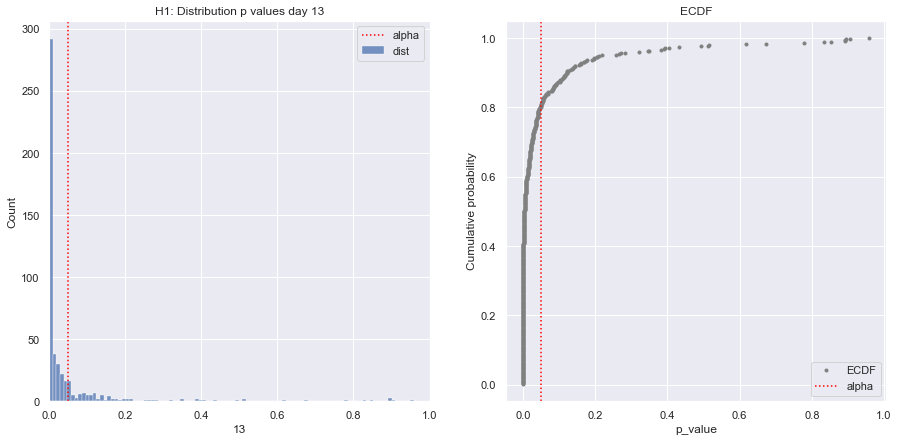

In [29]:
day = 13
ecdf = ECDF_vals(H1_frame.iloc[:,day])
percentiles_diff = np.percentile(H1_frame.iloc[:,day], [2.5,97.5])

# Left hand graph: distribution
fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
sns.histplot(H1_frame.iloc[:,day], bins = 100, ax = ax1, label = 'dist')
ax1.axvline(x= 0.05, color = 'red', linestyle = ':', label = 'alpha');
ax1.set_xlim(0,1)
ax1.set_title('H1: Distribution p values day {}'.format(day))
ax1.legend()

# Right hand graph: CDF
plot_ECDF(H1_frame.iloc[:,day], ax = ax2 )
ax2.axvline(x= 0.05, color = 'red', linestyle = ':', label = 'alpha');
ax2.legend()

#ax1.axvline(x= percentiles_diff[0], color = 'red');
#ax1.axvline(x= percentiles_diff[1], color = 'red');



plt.show()



## Taken from #https://cxl.com/blog/peeking-sequential-testing/

In [30]:
# POWER
#H1 tests that reach p < 0.05 at the end of testday 14 = 784 (78%)
print('Total tests =' ,H1_frame.shape[0])
print('POWER =',100.0 * (H1_frame.iloc[:,13]<0.05).sum() / H1_frame.shape[0], '%')

#FUTILITY
#H1 tests that had pvalue >0.5 on day 7  = 103 (10.3%)
print('FUTILITY: p > 0.5 on day 7')
print('FUTILE TESTS = ',(H1_frame.iloc[:,6]>0.50).sum())
print('FUTILE % = ', 100.0 * (H1_frame.iloc[:,6]>0.50).sum() /H1_frame.shape[0], '%')

#INCORRECT FUTILITY
#H1 tests that had pvalue >0.5 on day 7  = 103 (10.3%)
# AND reached p < 0.05 confidence at the end of test = 33
print('INCORRECT FUTILE TESTS =',100.0*H1_frame[(H1_frame.iloc[:,6]>0.50) & (H1_frame.iloc[:,13]<0.05)].shape[0] /H1_frame.shape[0], '%')

#CORRECT FUTILITY
#H1 tests that had pvalue >0.5 on day 7  = 103 (10.3%)
# AND DID NOT reached p < 0.05 confidence at the end of test = 33
print('CORRECT FUTILE TESTS =',100.0*H1_frame[(H1_frame.iloc[:,6]>0.50) & (H1_frame.iloc[:,13]>0.05)].shape[0] /H1_frame.shape[0], '%')


Total tests = 500
POWER = 80.6 %
FUTILITY: p > 0.5 on day 7
FUTILE TESTS =  49
FUTILE % =  9.8 %
INCORRECT FUTILE TESTS = 4.2 %
CORRECT FUTILE TESTS = 5.6 %


In [31]:
#Futility cost as a function of day of peek
#i.e. reduction in power
threshold = []
days = []
correct_futile = []
incorrect_futile = []

for d in range(13):
    for t in range(0,10,1):
        threshold.append(t/10)
        days.append(d)
        incorrect_futile.append(H1_frame[(H1_frame.iloc[:,d]>(t/10)) & (H1_frame.iloc[:,13]<0.05)].shape[0] / H1_frame.shape[0])
        correct_futile.append(H1_frame[(H1_frame.iloc[:,d]>(t/10)) & (H1_frame.iloc[:,13]>0.05)].shape[0] / H1_frame.shape[0])
    
futility_result_H1 = pd.DataFrame({'days':days, 'threshold':threshold, 'correct_futile':correct_futile, 'incorrect_futile':incorrect_futile})
futility_result_H1.head(50)


,days,threshold,correct_futile,incorrect_futile
0,0,0.00000,0.19400,0.80600
1,0,0.10000,0.17200,0.62000
2,0,0.20000,0.14600,0.53600
3,0,0.30000,0.12000,0.44000
4,0,0.40000,0.10200,0.35000
5,0,0.50000,0.09200,0.27600
6,0,0.60000,0.07200,0.23600
7,0,0.70000,0.05600,0.16600
8,0,0.80000,0.04000,0.10600
9,0,0.90000,0.02000,0.05200


# Multiple Variants and Bonferroni correction

Assume that we have several variants, each of which have no true effect. We conclude the experiment if any of the variants are statistically significant on day 14, what is the true type 1 error ? 

- x0 corresponds to the control with mean = 0.8
- x1 corresponds to a variant1 with true mean = 0.8
- x2 corresponds to a variant2 with true mean = 0.8


We see here that with two variants, by keeping $\alpha = 0.5$, we inflate the type 1 error to 8.9% instead of 5%. This issue is the well known [multiple comparison problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). On solution is to adjust $\alpha$ with the [bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) such that:

$\alpha_b = \frac{\alpha}{m}$

where $m$ is the number of comparisons (i.e. variants)


In [32]:
%%time
days = 14
sims = 1000
V1_frame, V2_frame = np.empty(days).reshape(1,days), np.empty(days).reshape(1,days)

#Looping through simulations
for i in range(sims-1):
    
    x0, x1, x2 = np.empty(0), np.empty(0), np.empty(0)
    t_test_p_V1, t_test_p_V2 = np.empty(0), np.empty(0)
    
    #Looping through days 
    for d in range(days):
        #print(d)
        daily_x0 = stats.norm.rvs(loc = mu0, scale =sigma0, size = 1000)
        daily_x1 = stats.norm.rvs(loc = mu0, scale = sigma1, size = 1000)
        daily_x2 = stats.norm.rvs(loc = mu0, scale = sigma0, size = 1000)

        x0 = np.append(x0, daily_x0.copy())
        x1 = np.append(x1, daily_x1.copy())
        x2 = np.append(x2, daily_x2.copy())
        #print(x0.shape)

        t_test_p_V1 = np.append(t_test_p_V1, stats.ttest_ind(x0,x1)[1].copy())
        t_test_p_V2 = np.append(t_test_p_V2, stats.ttest_ind(x0,x2)[1].copy())   
    
    #Stacking sim loop results
    V1_frame = np.vstack( (V1_frame,t_test_p_V1))
    V2_frame = np.vstack( (V2_frame,t_test_p_V2 ))

#Saving as DataFrame outside of the sim loop    
V1_frame = pd.DataFrame(V1_frame)
V2_frame = pd.DataFrame(V2_frame)


CPU times: user 34.4 s, sys: 237 ms, total: 34.7 s
Wall time: 43.5 s


### Bonferroni correction

In [33]:
#Calculations
number_sims = V1_frame.shape[0]
number_days = V1_frame.shape[1]
m = 2 #Number of variants


# i.e. True type 1 error in this scenario compared to expected
positive_sims = ( (V1_frame.iloc[:,13]<alpha) | (V2_frame.iloc[:,13]<alpha) ).sum()
print('True type 1 error when comparing two variants to the control:')
print('True =', 100 *positive_sims / number_sims, '%, Expected =', 100 * alpha, '%')

print()


# i.e. True type 1 error with Bonferroni correction
positive_sims = ( (V1_frame.iloc[:,13]<alpha/m) | (V2_frame.iloc[:,13]<alpha/m) ).sum()
print('True type 1 error with Bonferroni correction:')
print('True =', 100 *positive_sims / number_sims, '%, Expected =', 100 * alpha, '%')



True type 1 error when comparing two variants to the control:
True = 8.3 %, Expected = 5.0 %

True type 1 error with Bonferroni correction:
True = 3.8 %, Expected = 5.0 %


## Experiment 2) Two groups, same average, 50/50%, comparing superiority

The main difference with experiment 1 is that we are testing for superiority of a specific margin $\delta$

- $H_0$: $\mu_1 - \mu_0 < \delta$
- $H_1$: $\mu_1 - \mu_0 \geq \delta$
- Where $\delta = 0.01$ 
- Type 1 error is calculated as: $P(\text{reject} | H_0)$
- Power is calculated as: $P(\text{reject} | H_1)$

For $\mu_0 = 0.8 $ and $\mu_1 = 0.81$ then we cannot measure the difference. For For $\mu_0 = 0.8 $ and $\mu_1 = 0.82$ we need 14k users to achieve 80% power, a similar magnitude to the previous experiment, but with double the true difference between populations.


[Link](http://powerandsamplesize.com/Calculators/Compare-2-Means/2-Sample-Non-Inferiority-or-Superiority)


In [34]:
#Z_crit
alpha = .05
beta = 0.2 #Power = 1-beta
delta = 0.01

#Paramaters
mu0,mu1 = 0.80,0.82
sigma0, sigma1 = 0.3, 0.3
n0, n1 = 10000,10000

#Intermediate calculations
z_alpha2 = stats.norm.ppf(1-alpha/2, loc=0, scale=1)
z_beta = stats.norm.ppf(1-beta, loc=0, scale=1)

kappa = n0/n1
sigma_pooled = ( np.sqrt(( (n0-1)* sigma0**2 + (n1-1) * sigma1**2 ) / (n0+n1-2)) )


#Manual power
#from http://powerandsamplesize.com/Calculators/Compare-2-Means/2-Sample-Equality
z = (mu1-mu0-delta) / ( sigma_pooled * np.sqrt( (1/n0) + (1/n1) ) )
power_manual = stats.norm.cdf(z - z_alpha2, loc=0, scale=1) + stats.norm.cdf(-z - z_alpha2, loc=0, scale=1)

#Manual sample size given power
sample_size_n1 = (1 + 1/kappa)  * ( sigma_pooled * (z_alpha2 + z_beta) / (mu1-mu0-delta) )**2
sample_size_n0 = kappa * sample_size_n1

#Using statsmodel and standardized effect size, difference between the two means divided by the standard deviation. effect_size has to be positive.
power_statsmodel = statsmodels.stats.power.tt_ind_solve_power(effect_size = (mu1-mu0)/sigma_pooled, nobs1 = n1, ratio =n1/n2, alpha = 0.05, power = None, alternative = 'two-sided' )

#print('z_alpha/2 = ',z_alpha2, '  z = ', z)
print('Sample size for 80% power: n0=', round(sample_size_n1), 'and n1 =',round(sample_size_n0))
print('Power for given sample size = ', round(power_manual,4) ) 


NameError: name 'n2' is not defined